In [1]:
import tensorflow as tf 
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)
import random, numpy as np, os
#import tensorflow_datasets as tfds
#tfds.disable_progress_bar()
#tf.config.experimental.set_memory_growth(physical_devices[0], True)
#tf.config.run_functions_eagerly(True)
def config_gpu(mp=False):
    print('Eager Model : ', tf.executing_eagerly())
    print('TensorFlow Cuda Built Test : ', tf.test.is_built_with_cuda)
    print('TensorFlow GPU Detected : ', tf.test.gpu_device_name())
    print('TensorFlow System Cuda Version : ', tf.sysconfig.get_build_info()["cuda_version"])
    print('TensorFlow System CudNN Version : ', tf.sysconfig.get_build_info()["cudnn_version"] )

    AUTO = tf.data.AUTOTUNE
    GPUS = tf.config.list_physical_devices('GPU')
    if GPUS:
        try:
            for GPU in GPUS:
                tf.config.experimental.set_memory_growth(GPU, True)
                logical_gpus = tf.config.list_logical_devices('GPU')
                print(len(GPUS), "Physical GPUs,", len(logical_gpus), "Logical GPUs") 
        except RuntimeError as  RE:
            print(RE)
    if mp:
        tf.keras.mixed_precision.set_global_policy('mixed_float16')
        print('Mixed precision enabled')
        
#tf.keras.utils.set_random_seed(100)
config_gpu(mp=False)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Eager Model :  True
TensorFlow Cuda Built Test :  <function is_built_with_cuda at 0x7f341e971d80>
TensorFlow GPU Detected :  /device:GPU:0
TensorFlow System Cuda Version :  11.8
TensorFlow System CudNN Version :  8
1 Physical GPUs, 1 Logical GPUs


# <a id='intro'>Plan</a>
#### [Wavelet with residual block](#the_destination)
#### [Efficient-net](#Efficient_net)
#### [Ensemblelearning](#Ensemble_learning)
#### [Metrics with Graph](#graph)
#### [Grad-CAM](#Gradcam)
#### [Result Metrics](#metrics)

# <a id=''>TF Dataset and Preprocess</a>

In [2]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
from glob import glob
from sklearn.metrics import roc_curve, auc
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_auc_score
from tensorflow.keras import callbacks 
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from  matplotlib import pyplot as plt
from tensorflow.keras import Model
from keras.layers import Lambda
from tensorflow.keras.layers import concatenate,Dense, Conv2D, MaxPooling2D, Flatten,Input,Activation,add,AveragePooling2D,BatchNormalization,Dropout
%matplotlib inline
import shutil
from sklearn.metrics import  precision_score, recall_score, accuracy_score,classification_report ,confusion_matrix
from tensorflow.python.platform import build_info as tf_build_info
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from PIL import ImageFile

In [3]:
import os, cv2
import random, math
import numpy as np 
import pandas as pd
from PIL import Image
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt

import tensorflow, keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, Adam
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K

import warnings
warnings.filterwarnings('ignore')

In [4]:
train_path = "/kaggle/input/basedir/base_dir/train_dir"
test_path = "/kaggle/input/basedir/base_dir/val_dir"
batch_size = 16

train_batch_size = 4
val_batch_size = 4
image_size = 224


In [5]:
def custom_augmentation(np_tensor):
    # Randomly apply contrast adjustment
    if np.random.uniform() < 0.2:
        np_tensor = tf.image.random_contrast(np_tensor, lower=0.5, upper=2.0)

    # Randomly apply saturation adjustment
    if np.random.uniform() < 0.2:
        np_tensor = tf.image.random_saturation(np_tensor, lower=0.2, upper=3.0)

    # Randomly apply cropping
    if np.random.uniform() < 0.3:
        crop_fraction = np.random.uniform(0.7, 1.3)
        new_height = int(crop_fraction * np_tensor.shape[0])
        new_width = int(crop_fraction * np_tensor.shape[1])
        cropped = tf.image.resize_with_crop_or_pad(np_tensor, new_height, new_width)
        np_tensor = tf.image.resize(cropped, np_tensor.shape[:2])

    # Randomly apply Gaussian noise
    if np.random.uniform() < 0.3:
        mean = 0
        var = np.random.randint(1, 26)
        noise = np.random.normal(mean, var**0.5, np_tensor.shape)
        np_tensor = np.clip(np_tensor + noise, 0, 255).astype('int')

    # Randomly apply cutout
    if np.random.uniform() < 0.4:
        cutout_height = int(np.random.uniform(0.1, 0.2) * np_tensor.shape[0])
        cutout_width = int(np.random.uniform(0.1, 0.2) * np_tensor.shape[1])
        cutout_height_point = np.random.randint(np_tensor.shape[0] - cutout_height)
        cutout_width_point = np.random.randint(np_tensor.shape[1] - cutout_width)
        np_tensor[cutout_height_point:cutout_height_point + cutout_height,
                  cutout_width_point:cutout_width_point + cutout_width, :] = 127

    return np.array(np_tensor)

In [6]:

datagen = ImageDataGenerator(#preprocessing_function=custom_augmentation,
                            rescale=1./255,
                             preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
                            horizontal_flip = True,
                            vertical_flip=True
)
datagen1 = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
                             rescale=1./255,)
                             #horizontal_flip = True,
                             #vertical_flip=True,)


train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=train_batch_size,)
                                           #subset='training')

valid_batches = datagen.flow_from_directory(test_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size,)

test_batches = datagen1.flow_from_directory(test_path,
                                            target_size=(image_size,image_size),
                                            batch_size=32,
                                            shuffle=False,)
                                          #subset='validation')

Found 38569 images belonging to 7 classes.
Found 938 images belonging to 7 classes.
Found 938 images belonging to 7 classes.


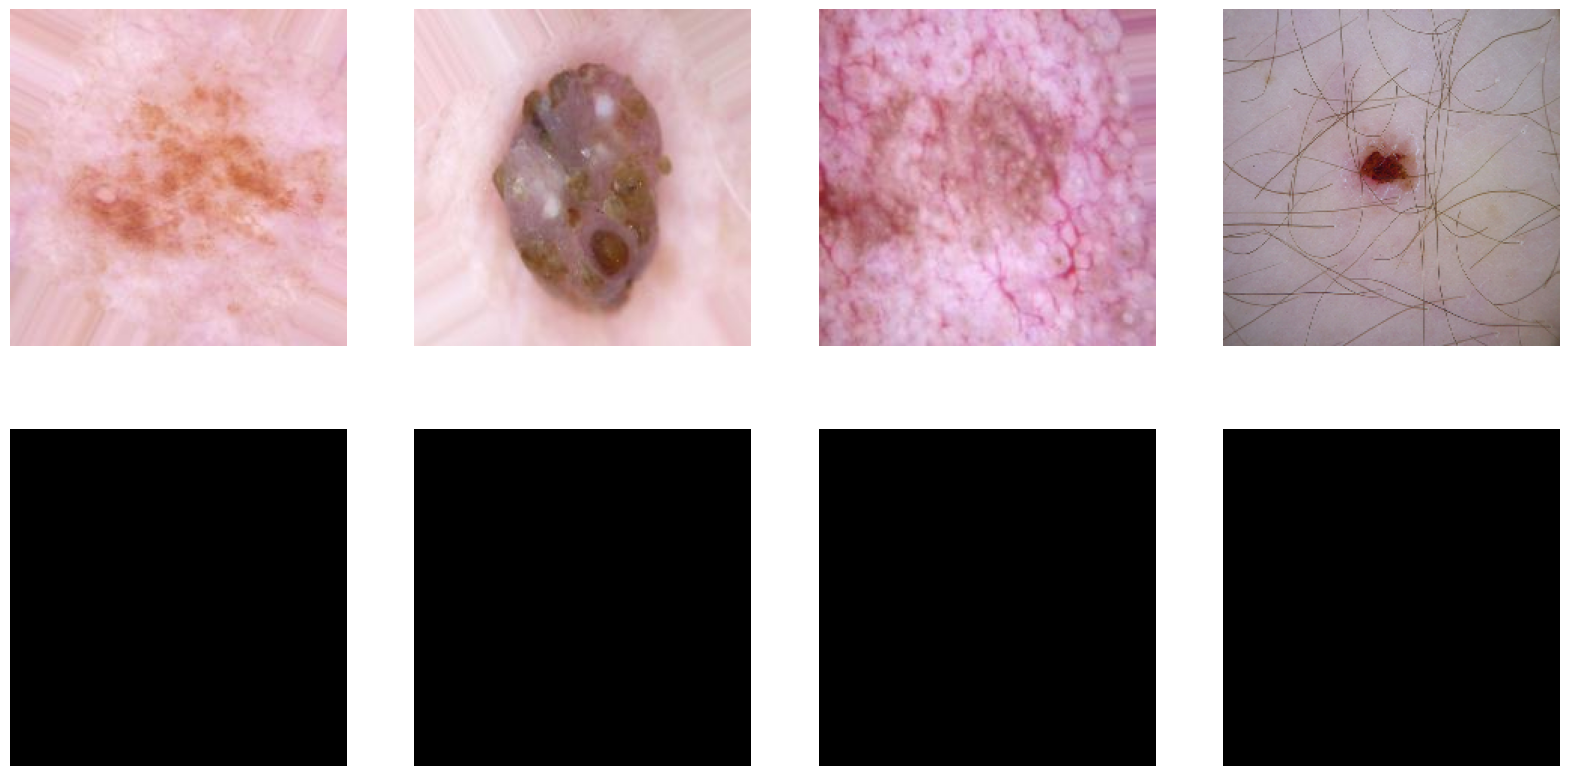

In [7]:
#densneet
%matplotlib inline
image, label = next(train_batches)
plt.figure(figsize=(20,10))
inline = 4
for i in range(inline):
    #print(image.size())
    plt.subplot(2, inline, i%inline +1)
    plt.axis('off')
    plt.imshow(image[i])
    #plt.title(f'Label: {label}')
    plt.subplot(2, inline, i%inline +5)
    plt.axis('off')
    plt.imshow(image[i].astype(np.uint8))

# Configuration

In [8]:
# Setting TPU as main device for training, if you get warnings while working with tpu's ignore them.

DEVICE = 'TPU'
if DEVICE == 'TPU':
    print('connecting to TPU...')
    try:        
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print('Could not connect to TPU')
        tpu = None

    if tpu:
        try:
            print('Initializing  TPU...')
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print('TPU initialized')
        except _:
            print('Failed to initialize TPU!')
    else:
        DEVICE = 'GPU'

if DEVICE != 'TPU':
    print('Using default strategy for CPU and single GPU')
    strategy = tf.distribute.get_strategy()

if DEVICE == 'GPU':
    print('Num GPUs Available: ',
          len(tf.config.experimental.list_physical_devices('GPU')))

print('REPLICAS: ', strategy.num_replicas_in_sync)
AUTO = tf.data.experimental.AUTOTUNE

connecting to TPU...
Could not connect to TPU
Using default strategy for CPU and single GPU
Num GPUs Available:  1
REPLICAS:  1


In [9]:
cfg = dict(
           batch_size=4,
           img_size=384,
    
           lr_start=0.000005,
           lr_max=0.00000125,
           lr_min=0.000001,
           lr_rampup=5,
           lr_sustain=0,
           lr_decay=0.8,
           epochs=12,
    
           transform_prob=1.0,
           rot=180.0,
           shr=2.0,
           hzoom=8.0,
           wzoom=8.0,
           hshift=8.0,
           wshift=8.0,
    
           optimizer='adam',
           label_smooth_fac=0.05,
           tta_steps=20
            
        )

# <a id='the_destination'>Wavelet with residual block</a>
#### [Return Contents](#intro)

In [10]:
# batch operation usng tensor slice
def WaveletTransformAxisY(batch_img):
    odd_img  = batch_img[:,0::2]
    even_img = batch_img[:,1::2]
    L = (odd_img + even_img) / 2.0
    H = K.abs(odd_img - even_img)
    return L, H

def WaveletTransformAxisX(batch_img):
    # transpose + fliplr
    tmp_batch = K.permute_dimensions(batch_img, [0, 2, 1])[:,:,::-1]
    _dst_L, _dst_H = WaveletTransformAxisY(tmp_batch)
    # transpose + flipud
    dst_L = K.permute_dimensions(_dst_L, [0, 2, 1])[:,::-1,...]
    dst_H = K.permute_dimensions(_dst_H, [0, 2, 1])[:,::-1,...]
    return dst_L, dst_H

In [11]:
def Wavelet(batch_image):
    # make channel first image
    batch_image = K.permute_dimensions(batch_image, [0, 3, 1, 2])
    r = batch_image[:,0]
    g = batch_image[:,1]
    b = batch_image[:,2]

    # level 1 decomposition
    wavelet_L, wavelet_H = WaveletTransformAxisY(r)
    r_wavelet_LL, r_wavelet_LH = WaveletTransformAxisX(wavelet_L)
    r_wavelet_HL, r_wavelet_HH = WaveletTransformAxisX(wavelet_H)

    wavelet_L, wavelet_H = WaveletTransformAxisY(g)
    g_wavelet_LL, g_wavelet_LH = WaveletTransformAxisX(wavelet_L)
    g_wavelet_HL, g_wavelet_HH = WaveletTransformAxisX(wavelet_H)

    wavelet_L, wavelet_H = WaveletTransformAxisY(b)
    b_wavelet_LL, b_wavelet_LH = WaveletTransformAxisX(wavelet_L)
    b_wavelet_HL, b_wavelet_HH = WaveletTransformAxisX(wavelet_H)

    wavelet_data = [r_wavelet_LL, r_wavelet_LH, r_wavelet_HL, r_wavelet_HH, 
                    g_wavelet_LL, g_wavelet_LH, g_wavelet_HL, g_wavelet_HH,
                    b_wavelet_LL, b_wavelet_LH, b_wavelet_HL, b_wavelet_HH]
    transform_batch = K.stack(wavelet_data, axis=1)

    # level 2 decomposition
    wavelet_L2, wavelet_H2 = WaveletTransformAxisY(r_wavelet_LL)
    r_wavelet_LL2, r_wavelet_LH2 = WaveletTransformAxisX(wavelet_L2)
    r_wavelet_HL2, r_wavelet_HH2 = WaveletTransformAxisX(wavelet_H2)

    wavelet_L2, wavelet_H2 = WaveletTransformAxisY(g_wavelet_LL)
    g_wavelet_LL2, g_wavelet_LH2 = WaveletTransformAxisX(wavelet_L2)
    g_wavelet_HL2, g_wavelet_HH2 = WaveletTransformAxisX(wavelet_H2)

    wavelet_L2, wavelet_H2 = WaveletTransformAxisY(b_wavelet_LL)
    b_wavelet_LL2, b_wavelet_LH2 = WaveletTransformAxisX(wavelet_L2)
    b_wavelet_HL2, b_wavelet_HH2 = WaveletTransformAxisX(wavelet_H2)


    wavelet_data_l2 = [r_wavelet_LL2, r_wavelet_LH2, r_wavelet_HL2, r_wavelet_HH2, 
                    g_wavelet_LL2, g_wavelet_LH2, g_wavelet_HL2, g_wavelet_HH2,
                    b_wavelet_LL2, b_wavelet_LH2, b_wavelet_HL2, b_wavelet_HH2]
    transform_batch_l2 = K.stack(wavelet_data_l2, axis=1)

    # level 3 decomposition
    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(r_wavelet_LL2)
    r_wavelet_LL3, r_wavelet_LH3 = WaveletTransformAxisX(wavelet_L3)
    r_wavelet_HL3, r_wavelet_HH3 = WaveletTransformAxisX(wavelet_H3)

    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(g_wavelet_LL2)
    g_wavelet_LL3, g_wavelet_LH3 = WaveletTransformAxisX(wavelet_L3)
    g_wavelet_HL3, g_wavelet_HH3 = WaveletTransformAxisX(wavelet_H3)

    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(b_wavelet_LL2)
    b_wavelet_LL3, b_wavelet_LH3 = WaveletTransformAxisX(wavelet_L3)
    b_wavelet_HL3, b_wavelet_HH3 = WaveletTransformAxisX(wavelet_H3)

    wavelet_data_l3 = [r_wavelet_LL3, r_wavelet_LH3, r_wavelet_HL3, r_wavelet_HH3, 
                    g_wavelet_LL3, g_wavelet_LH3, g_wavelet_HL3, g_wavelet_HH3,
                    b_wavelet_LL3, b_wavelet_LH3, b_wavelet_HL3, b_wavelet_HH3]
    transform_batch_l3 = K.stack(wavelet_data_l3, axis=1)

    # level 4 decomposition
    wavelet_L4, wavelet_H4 = WaveletTransformAxisY(r_wavelet_LL3)
    r_wavelet_LL4, r_wavelet_LH4 = WaveletTransformAxisX(wavelet_L4)
    r_wavelet_HL4, r_wavelet_HH4 = WaveletTransformAxisX(wavelet_H4)

    wavelet_L4, wavelet_H4 = WaveletTransformAxisY(g_wavelet_LL3)
    g_wavelet_LL4, g_wavelet_LH4 = WaveletTransformAxisX(wavelet_L4)
    g_wavelet_HL4, g_wavelet_HH4 = WaveletTransformAxisX(wavelet_H4)

    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(b_wavelet_LL3)
    b_wavelet_LL4, b_wavelet_LH4 = WaveletTransformAxisX(wavelet_L4)
    b_wavelet_HL4, b_wavelet_HH4 = WaveletTransformAxisX(wavelet_H4)


    wavelet_data_l4 = [r_wavelet_LL4, r_wavelet_LH4, r_wavelet_HL4, r_wavelet_HH4, 
                    g_wavelet_LL4, g_wavelet_LH4, g_wavelet_HL4, g_wavelet_HH4,
                    b_wavelet_LL4, b_wavelet_LH4, b_wavelet_HL4, b_wavelet_HH4]
    transform_batch_l4 = K.stack(wavelet_data_l4, axis=1)

    # print('shape before')
    # print(transform_batch.shape)
    # print(transform_batch_l2.shape)
    # print(transform_batch_l3.shape)
    # print(transform_batch_l4.shape)

    decom_level_1 = K.permute_dimensions(transform_batch, [0, 2, 3, 1])
    decom_level_2 = K.permute_dimensions(transform_batch_l2, [0, 2, 3, 1])
    decom_level_3 = K.permute_dimensions(transform_batch_l3, [0, 2, 3, 1])
    decom_level_4 = K.permute_dimensions(transform_batch_l4, [0, 2, 3, 1])
    
    # print('shape after')
    # print(decom_level_1.shape)
    # print(decom_level_2.shape)
    # print(decom_level_3.shape)
    # print(decom_level_4.shape)
    return [decom_level_1, decom_level_2,decom_level_3,decom_level_4]


def Wavelet_out_shape(input_shapes):
    # print('in to shape')
    return [tuple([None, 112, 112, 12]), tuple([None, 56, 56, 12]), 
            tuple([None, 28, 28, 12]), tuple([None, 14, 14, 12])]

In [12]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model

# Fonction pour créer un bloc résiduel
def residual_block(x, filters, strides=(1, 1)):
    # Couches de convolution du bloc résiduel
    shortcut = x
    x = Conv2D(filters, kernel_size=(3, 3), strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    # Connexion résiduelle
    if strides != (1, 1) or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=(1, 1), strides=strides, padding='same')(shortcut)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x
class SpatialAttention(tf.keras.layers.Layer):
      def __init__(self, kernel_size):
        super(SpatialAttention, self).__init__()
        self.kernel_size = kernel_size
        
        def build(self, input_shape):
            self.conv2d = tf.keras.layers.Conv2D(filters = 1,
                    kernel_size=self.kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)

        def call(self, inputs):
            
            # AvgPool
            avg_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=3, keepdims=True))(inputs)
            
            # MaxPool
            max_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.max(x, axis=3, keepdims=True))(inputs)

            attention = tf.keras.layers.Concatenate(axis=3)([avg_pool, max_pool])

            attention = self.conv2d(attention)


            return tf.keras.layers.multiply([inputs, attention]) 
class ChannelAttention(tf.keras.layers.Layer):
      def __init__(self, filters, ratio):
        super(ChannelAttention, self).__init__()
        self.filters = filters
        self.ratio = ratio

        def build(self, input_shape):
            self.shared_layer_one = tf.keras.layers.Dense(self.filters//self.ratio,
                             activation='relu', kernel_initializer='he_normal', 
                              use_bias=True, 
                              bias_initializer='zeros')
            self.shared_layer_two = tf.keras.layers.Dense(self.filters,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')

        def call(self, inputs):
            # AvgPool
            avg_pool = tf.keras.layers.GlobalAveragePooling2D()(inputs)
            

            avg_pool = self.shared_layer_one(avg_pool)
            avg_pool = self.shared_layer_two(avg_pool)

            # MaxPool
            max_pool = tf.keras.layers.GlobalMaxPooling2D()(inputs)
            max_pool = tf.keras.layers.Reshape((1,1,filters))(max_pool)

            max_pool = shared_layer_one(max_pool)
            max_pool = shared_layer_two(max_pool)


            attention = tf.keras.layers.Add()([avg_pool,max_pool])
            attention = tf.keras.layers.Activation('sigmoid')(attention)
            
            return tf.keras.layers.Multiply()([inputs, attention])
def get_wavelet_cnn_model():
    input_shape = 224, 224, 3

    input_ = Input(input_shape, name='the_input')
    wavelet = Lambda(Wavelet, Wavelet_out_shape, name='wavelet')
    input_l1, input_l2, input_l3, input_l4 = wavelet(input_)

    # Adjust the number of channels in wavelet decomposition output
    input_l1 = Conv2D(64, kernel_size=(1, 1), padding='same', name='adjust_channels_l1')(input_l1)
    input_l2 = Conv2D(64, kernel_size=(1, 1), padding='same', name='adjust_channels_l2')(input_l2)
    input_l3 = Conv2D(64, kernel_size=(1, 1), padding='same', name='adjust_channels_l3')(input_l3)
    input_l4 = Conv2D(64, kernel_size=(1, 1), padding='same', name='adjust_channels_l4')(input_l4)

    # Architecture ResNet avec les blocs résiduels et les blocs de transformation en ondelettes

    x = input_
    x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)



    # Niveau 1
    x = input_l1
    relu_a = residual_block(x, filters=64, strides=(2, 2))
    #relu_a=ChannelAttention(128, 8)(relu_a)
    relu_a=SpatialAttention(10)(relu_a)

    # Niveau 2
    x = input_l2
    for _ in range(2):
        relu_1_2 = residual_block(x, filters=64)
    #relu_1_2=ChannelAttention(128, 8)(relu_1_2)
    relu_1_2=SpatialAttention(10)(relu_1_2)
      
    print("conc")
    concate_level_2 = concatenate([relu_1_2, relu_a])
    relu_2_2 = residual_block(concate_level_2, filters=128, strides=(2, 2))
    print(relu_2_2)
        
        
    x = input_l3
    relu_b_2 = residual_block(x, filters=64)
    for _ in range(2):
        relu_b_2 = residual_block(relu_b_2, filters=128)
    #relu_b_2=ChannelAttention(128, 8)(relu_b_2)
    relu_b_2=SpatialAttention(10)(relu_b_2)

    concate_level_3 = concatenate([relu_2_2, relu_b_2])
    print("conc")
    print(concate_level_3)
    relu_3_2 = residual_block(concate_level_3, filters=256, strides=(2, 2))
    
    # Niveau 3
    x = input_l4
    relu_c_3 = residual_block(x, filters=64)
    for _ in range(2):
        relu_c_3 = residual_block(relu_c_3, filters=256)
    #relu_c_3=ChannelAttention(128, 8)(relu_c_3)
    relu_c_3=SpatialAttention(10)(relu_c_3)
    concate_level_4 = concatenate([relu_3_2, relu_c_3])
    print("conc")
    print(concate_level_4)
    conv_4 = Conv2D(256, kernel_size=(3, 3), padding='same', name='conv_4')(concate_level_4)
    norm_4 = BatchNormalization(name='norm_4')(conv_4)
    relu_4 = Activation('relu', name='relu_4')(norm_4)

    conv_4_2 = Conv2D(256, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_4_2')(relu_4)
    norm_4_2 = BatchNormalization(name='norm_4_2')(conv_4_2)
    relu_4_2 = Activation('relu', name='relu_4_2')(norm_4_2)

    conv_5_1 = Conv2D(128, kernel_size=(3, 3), padding='same', name='conv_5_1')(relu_4_2)
    norm_5_1 = BatchNormalization(name='norm_5_1')(conv_5_1)
    relu_5_1 = Activation('relu', name='relu_5_1')(norm_5_1)

    pool_5_1 = AveragePooling2D(pool_size=(7, 7), strides=1, padding='same', name='avg_pool_5_1')(relu_5_1)
    flat_5_1 = Flatten(name='flat_5_1')(pool_5_1) 
    
    fc_5 = Dense(2048, name='fc_5')(flat_5_1)
    norm_5 = BatchNormalization(name='norm_5')(fc_5)
    relu_5 = Activation('relu', name='relu_5')(norm_5)
    drop_5 = Dropout(0.5, name='drop_5')(relu_5)

    fc_6 = Dense(2048, name='fc_6')(drop_5)
    norm_6 = BatchNormalization(name='norm_6')(fc_6)
    relu_6 = Activation('relu', name='relu_6')(norm_6)
    drop_6 = Dropout(0.5, name='drop_6')(relu_6)

    output = Dense(7, activation='softmax', name='fc_7')(drop_6)
    
    model = Model(inputs=input_, outputs=output)

    return model

In [13]:
#wavelet model
wavelet = get_wavelet_cnn_model()

conc
KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 128), dtype=tf.float32, name=None), name='activation_8/Relu:0', description="created by layer 'activation_8'")
conc
KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 256), dtype=tf.float32, name=None), name='concatenate_1/concat:0', description="created by layer 'concatenate_1'")
conc
KerasTensor(type_spec=TensorSpec(shape=(None, 14, 14, 512), dtype=tf.float32, name=None), name='concatenate_2/concat:0', description="created by layer 'concatenate_2'")


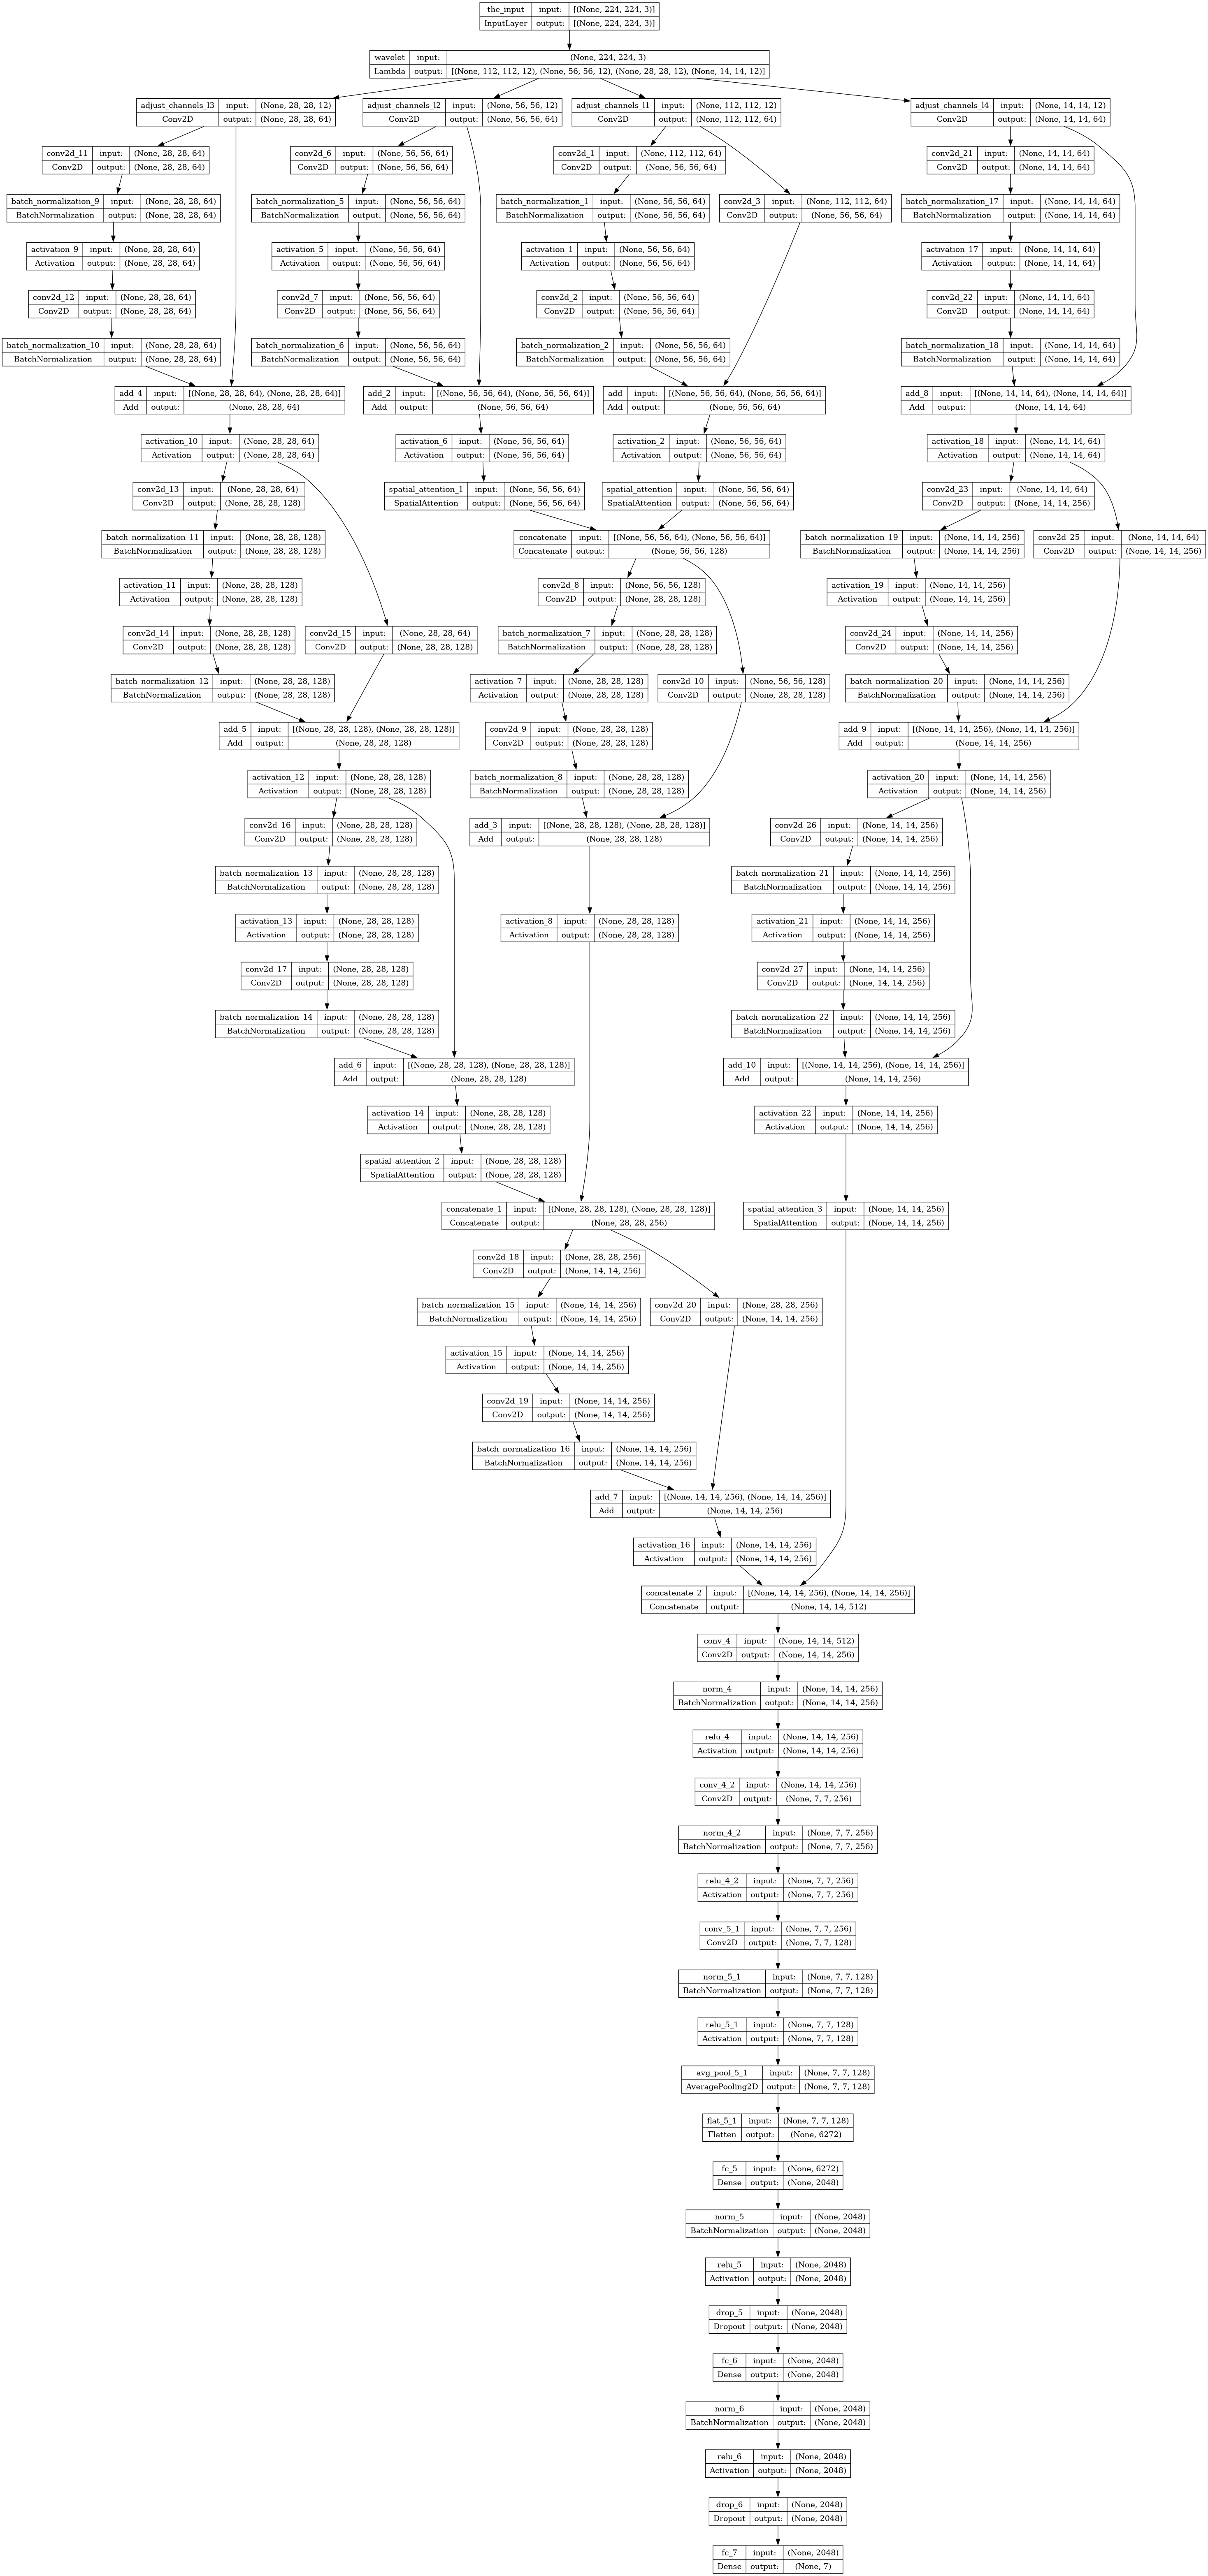

In [14]:
import tensorflow as tf 
display(tf.keras.utils.plot_model(wavelet, 
                                  show_shapes=True, 
                                  show_layer_names=True,
                                  expand_nested=True))

In [15]:
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers

# Multi-Atrous Branch
class MultiAtrous(keras.Model):
    def __init__(self, 
                 dilation_rates=[6, 12, 18], 
                 upsampling=1, 
                 kernel_size=3, 
                 padding="same",  **kwargs):
        super(MultiAtrous, self).__init__(name='MultiAtrous', **kwargs)
        self.dilation_rates = dilation_rates
        self.kernel_size = kernel_size 
        self.upsampling = upsampling
        self.padding = padding
      
        # Dilated Convolutions                     
        self.dilated_convs = [
                              layers.Conv2D(
                                  filters       = int(1024 / 4), 
                                  kernel_size   = self.kernel_size,  
                                  padding       = self.padding, 
                                  dilation_rate = rate
                                ) for rate in self.dilation_rates
                             ]
        
        # Global Average Pooling Branch 
        self.gap_branch = keras.Sequential(
            [
                layers.GlobalAveragePooling2D(keepdims=True),
                layers.Conv2D(int(1024 / 2), kernel_size=1),
                layers.Activation('relu'),
                layers.UpSampling2D(size=self.upsampling, interpolation="bilinear")
            ] , name='gap_branch'
        )
        
    def call(self, inputs, training=None, **kwargs):
        local_feature = []
        for dilated_conv in self.dilated_convs:
            x = dilated_conv(inputs) 
            x = self.gap_branch(x)
            local_feature.append(x)
        return tf.concat(local_feature, axis=-1)

    def get_config(self):
        config = {
            'dilation_rates': self.dilation_rates,
            'kernel_size'   : self.kernel_size,
            'padding'       : self.padding,
            'upsampling'    : self.upsampling
        }
        base_config = super(MultiAtrous, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [16]:
class GeneralizedMeanPooling2D(layers.Layer):
    def __init__(self, init_norm=3.0, normalize=False, epsilon=1e-6, **kwargs):
        self.init_norm = init_norm
        self.normalize = normalize
        self.epsilon   = epsilon
        super(GeneralizedMeanPooling2D, self).__init__(**kwargs)

    def build(self, input_shape):
        self.p = self.add_weight(name="norms", 
                                 shape=(input_shape[-1],),
                                 initializer=keras.initializers.constant(self.init_norm),
                                 trainable=True)
        super(GeneralizedMeanPooling2D, self).build(input_shape)

    def call(self, inputs):
        x = tf.abs(tf.maximum(self.epsilon, inputs))
        x = tf.pow(x, self.p)
        x = tf.reduce_mean(x, axis=[1,2], keepdims=False) 
        x = tf.pow(x, (1.0 / self.p))
        if self.normalize:
            x = tf.nn.l2_normalize(x, 1)
        return x

    def get_config(self):
        config = {
            'init_norm' : self.init_norm,
            'normalize' : self.normalize,
            'epsilon'   : self.epsilon
        }
        base_config = super(GeneralizedMeanPooling2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [17]:
class SkinNet(keras.Model):
    def __init__(self, backbone=None, num_classes=1, activation=None, **kwargs):
        super(SkinNet, self).__init__(name='SkinNet', **kwargs)
        # Number of classes 
        self.num_classes = num_classes
        self.activation  = activation
        
        # Base blcoks 
        self.base = backbone
        self.base_input_shape  = self.base.input_shape[0][1]

        self.glob_branch_pool = keras.Sequential(
            [
                GeneralizedMeanPooling2D(),
                layers.Dense(1024, activation=None)
            ], 
            name='GlobalBranchPooling'
        )
        
        # Head block
        self.classifier = keras.Sequential(
            [
                #layers.GlobalAveragePooling2D(name='HeadGAP'),
                layers.Dense(self.num_classes, activation = self.activation)
            ], 
            name='Classifiers'
        )
       
    # forwarding the computation 
    def call(self, inputs, training=None, **kwargs):
        # Get tensor from target layers 
        to_global= self.base(inputs)

        # Pass the received tensor to Top building blocks 
        global_feat    = self.glob_branch_pool(to_global)
        return self.classifier(global_feat)
    """
    def train_step(self, data):
        return train_step_sam(self, data, rho=0.05)
    """

    def build_graph(self):
        x = keras.Input(shape=(self.base_input_shape, self.base_input_shape, 3))
        return keras.Model(inputs=[x], outputs=self.call(x))

In [18]:
from tensorflow.keras import applications, layers, Model, Input

for l in wavelet.layers:
    print(l.name, l.output_shape)  

the_input [(None, 224, 224, 3)]
wavelet [(None, 112, 112, 12), (None, 56, 56, 12), (None, 28, 28, 12), (None, 14, 14, 12)]
adjust_channels_l3 (None, 28, 28, 64)
conv2d_11 (None, 28, 28, 64)
batch_normalization_9 (None, 28, 28, 64)
activation_9 (None, 28, 28, 64)
conv2d_12 (None, 28, 28, 64)
batch_normalization_10 (None, 28, 28, 64)
adjust_channels_l2 (None, 56, 56, 64)
adjust_channels_l1 (None, 112, 112, 64)
add_4 (None, 28, 28, 64)
conv2d_6 (None, 56, 56, 64)
conv2d_1 (None, 56, 56, 64)
activation_10 (None, 28, 28, 64)
batch_normalization_5 (None, 56, 56, 64)
batch_normalization_1 (None, 56, 56, 64)
conv2d_13 (None, 28, 28, 128)
adjust_channels_l4 (None, 14, 14, 64)
activation_5 (None, 56, 56, 64)
activation_1 (None, 56, 56, 64)
batch_normalization_11 (None, 28, 28, 128)
conv2d_21 (None, 14, 14, 64)
conv2d_7 (None, 56, 56, 64)
conv2d_2 (None, 56, 56, 64)
activation_11 (None, 28, 28, 128)
batch_normalization_17 (None, 14, 14, 64)
batch_normalization_6 (None, 56, 56, 64)
batch_normaliza

In [19]:
#9bel mnni kente dayra wavelet 3adi bla residual block kent dayra ghir model.input ms 3tatni error 'nonetype' dkchi 3lash
#beddeltha b hadi model.inputs
new_base = keras.Model(
    [wavelet.inputs], 
    [
        wavelet.get_layer('relu_4').output # for global branch (None, 14, 14, 256)
    ], 
    name='Wavelet'
)

In [20]:
skin_net = SkinNet(new_base, num_classes=7, activation='softmax')
skin_net.build_graph().summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 Wavelet (Functional)        (None, 14, 14, 256)       5512256   
                                                                 
 GlobalBranchPooling (Seque  (None, 1024)              263424    
 ntial)                                                          
                                                                 
 Classifiers (Sequential)    (None, 7)                 7175      
                                                                 
Total params: 5782855 (22.06 MB)
Trainable params: 5776711 (22.04 MB)
Non-trainable params: 6144 (24.00 KB)
_________________________________________________________________


In [21]:
tf.config.optimizer.set_jit(True)
def compileNewModel():
    
    ''' Configuring the model with losses and metrics. '''    
    
    with strategy.scope():
        model = skin_net

    with strategy.scope():
        model.compile(optimizer='adam', loss='categorical_crossentropy', 
                      metrics=['accuracy'])
        #tf.keras.metrics.AUC(name='auc')
    return model

def getLearnRateCallback(cfg):
    
    ''' Using callbacks for learning rate adjustments. '''
    
    lr_start = cfg['lr_start']
    lr_max = cfg['lr_max'] * strategy.num_replicas_in_sync * cfg['batch_size']
    lr_min = cfg['lr_min']
    lr_rampup = cfg['lr_rampup']
    lr_sustain = cfg['lr_sustain']
    lr_decay = cfg['lr_decay']

    def lrfn(epoch):
        if epoch < lr_rampup:
            lr = (lr_max - lr_start) / lr_rampup * epoch + lr_start
        elif epoch < lr_rampup + lr_sustain:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_rampup -
                                                lr_sustain) + lr_min
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback


def learnModel(model, ds_train, cfg, ds_val):
    
    ''' Fitting things together for training '''
    
    filepath1 = "Skin_attent_weights_acc_att_wave_14.h5"
    checkpoint = ModelCheckpoint(filepath1, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True)
    callbacks = [getLearnRateCallback(cfg), checkpoint]

    history = model.fit(ds_train,
                        validation_data=ds_val,
                        verbose=True,
                        epochs=200,
                        callbacks=callbacks)

    return history

model = compileNewModel()
history = learnModel(model, train_batches, cfg, valid_batches)

In [22]:
model = compileNewModel()
history = learnModel(model, train_batches, cfg, valid_batches)

Epoch 1/200
9642/9643 [============================>.] - ETA: 0s - loss: 1.1848 - accuracy: 0.5486
Epoch 1: val_accuracy improved from -inf to 0.84222, saving model to Skin_attent_weights_acc_att_wave_14.h5
9643/9643 [==============================] - 433s 42ms/step - loss: 1.1848 - accuracy: 0.5486 - val_loss: 0.4388 - val_accuracy: 0.8422 - lr: 5.0000e-06
Epoch 2/200
9642/9643 [============================>.] - ETA: 0s - loss: 0.9084 - accuracy: 0.6554
Epoch 2: val_accuracy improved from 0.84222 to 0.85821, saving model to Skin_attent_weights_acc_att_wave_14.h5
9643/9643 [==============================] - 199s 21ms/step - loss: 0.9085 - accuracy: 0.6554 - val_loss: 0.4116 - val_accuracy: 0.8582 - lr: 5.0000e-06
Epoch 3/200
9641/9643 [============================>.] - ETA: 0s - loss: 0.7978 - accuracy: 0.6977
Epoch 3: val_accuracy improved from 0.85821 to 0.86461, saving model to Skin_attent_weights_acc_att_wave_14.h5
9643/9643 [==============================] - 189s 20ms/step - loss:

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



9643/9643 [==============================] - ETA: 0s - loss: 0.3845 - accuracy: 0.8610
Epoch 23: val_accuracy did not improve from 0.88486
9643/9643 [==============================] - 194s 20ms/step - loss: 0.3845 - accuracy: 0.8610 - val_loss: 0.3698 - val_accuracy: 0.8795 - lr: 1.0901e-06
Epoch 24/200
9642/9643 [============================>.] - ETA: 0s - loss: 0.3784 - accuracy: 0.8621
Epoch 24: val_accuracy improved from 0.88486 to 0.88806, saving model to Skin_attent_weights_acc_att_wave_14.h5
9643/9643 [==============================] - 196s 20ms/step - loss: 0.3784 - accuracy: 0.8621 - val_loss: 0.3547 - val_accuracy: 0.8881 - lr: 1.0721e-06
Epoch 25/200
9641/9643 [============================>.] - ETA: 0s - loss: 0.3737 - accuracy: 0.8655
Epoch 25: val_accuracy did not improve from 0.88806
9643/9643 [==============================] - 187s 19ms/step - loss: 0.3737 - accuracy: 0.8655 - val_loss: 0.3658 - val_accuracy: 0.8742 - lr: 1.0576e-06
Epoch 26/200
9643/9643 [==============

In [23]:
#dolg_net.load_weights('Skin_attent_weights_acc_att_wave_14.h5')

In [27]:
pwd

'/kaggle/working'

In [26]:
model.save_weights('Skin_attent_weights_acc_att_wave_14.h5')

# <a id='Efficient_net'>Efficient-net</a>
#### [Return Contents](#intro)

In [25]:
predictions = model.predict(test_batches, steps=len(test_batches), verbose=0)
#geting predictions on test dataset
y_pred = np.argmax(predictions, axis=1)
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
#getting the true labels per image 
y_true = test_batches.classes
#getting the predicted labels per image 
y_prob=predictions
from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

# Creating classification report 
report = classification_report(y_true, y_pred, target_names=targetnames)

print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

       akiec       0.64      0.54      0.58        26
         bcc       0.73      0.80      0.76        30
         bkl       0.66      0.59      0.62        75
          df       0.44      0.67      0.53         6
         mel       0.42      0.41      0.42        39
          nv       0.95      0.96      0.95       751
        vasc       0.79      1.00      0.88        11

    accuracy                           0.89       938
   macro avg       0.66      0.71      0.68       938
weighted avg       0.88      0.89      0.88       938



In [28]:
import seaborn as sns
def plot_training_curves(history, ):
    
    loss = np.array(history.history['loss'])
    val_loss = np.array(history.history['val_loss'])

    accuracy = np.array(history.history['accuracy'])
    val_accuracy = np.array(history.history['val_accuracy'])

    epochs = range(len(history.history['loss']))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # Plot loss
    ax1.plot(epochs, loss, label='training_loss', marker='o')
    ax1.plot(epochs, val_loss, label='val_loss', marker='o')
    
    ax1.fill_between(epochs, loss, val_loss, where=(loss > val_loss), color='C0', alpha=0.3, interpolate=True)
    ax1.fill_between(epochs, loss, val_loss, where=(loss < val_loss), color='C1', alpha=0.3, interpolate=True)

    ax1.set_title('Loss (Lower Means Better)', fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.legend()

    # Plot accuracy
    ax2.plot(epochs, accuracy, label='training_accuracy', marker='o')
    ax2.plot(epochs, val_accuracy, label='val_accuracy', marker='o')
    
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy > val_accuracy), color='C0', alpha=0.3, interpolate=True)
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy < val_accuracy), color='C1', alpha=0.3, interpolate=True)

    ax2.set_title('Accuracy (Higher Means Better)', fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.legend();
    
    sns.despine();

In [29]:
def info_layers(model ):
    # вывод информации по слоям модели в процессе тюнинга
    
    print("Number of layers in the model:", len(model.layers))
    print("Number of trainable_variables layers in the model:", len(model.trainable_variables))
    #print("Number of layers in the base model: ", len(base_model.layers))
    #print("Number of variables layers in the base model: ", len(base_model.trainable_variables))
    #print("Layers in the model:")
    #for layer in model.layers:
     #   print(layer, layer.trainable)

def graph(history):
    # построние графиков изменения метрики и функции потерь в процессе обучения по эпохам
    
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['accuracy'], 'b*-', label="training acc")
    plt.plot(history.history['val_accuracy'], 'r*-', label="validation acc")
    plt.grid()
    plt.title("train_acc vs val_acc")
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], 'b*-', label="training loss")
    plt.plot(history.history['val_loss'], 'r*-', label="validation loss")
    plt.grid()
    plt.title("Training and validation loss")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()

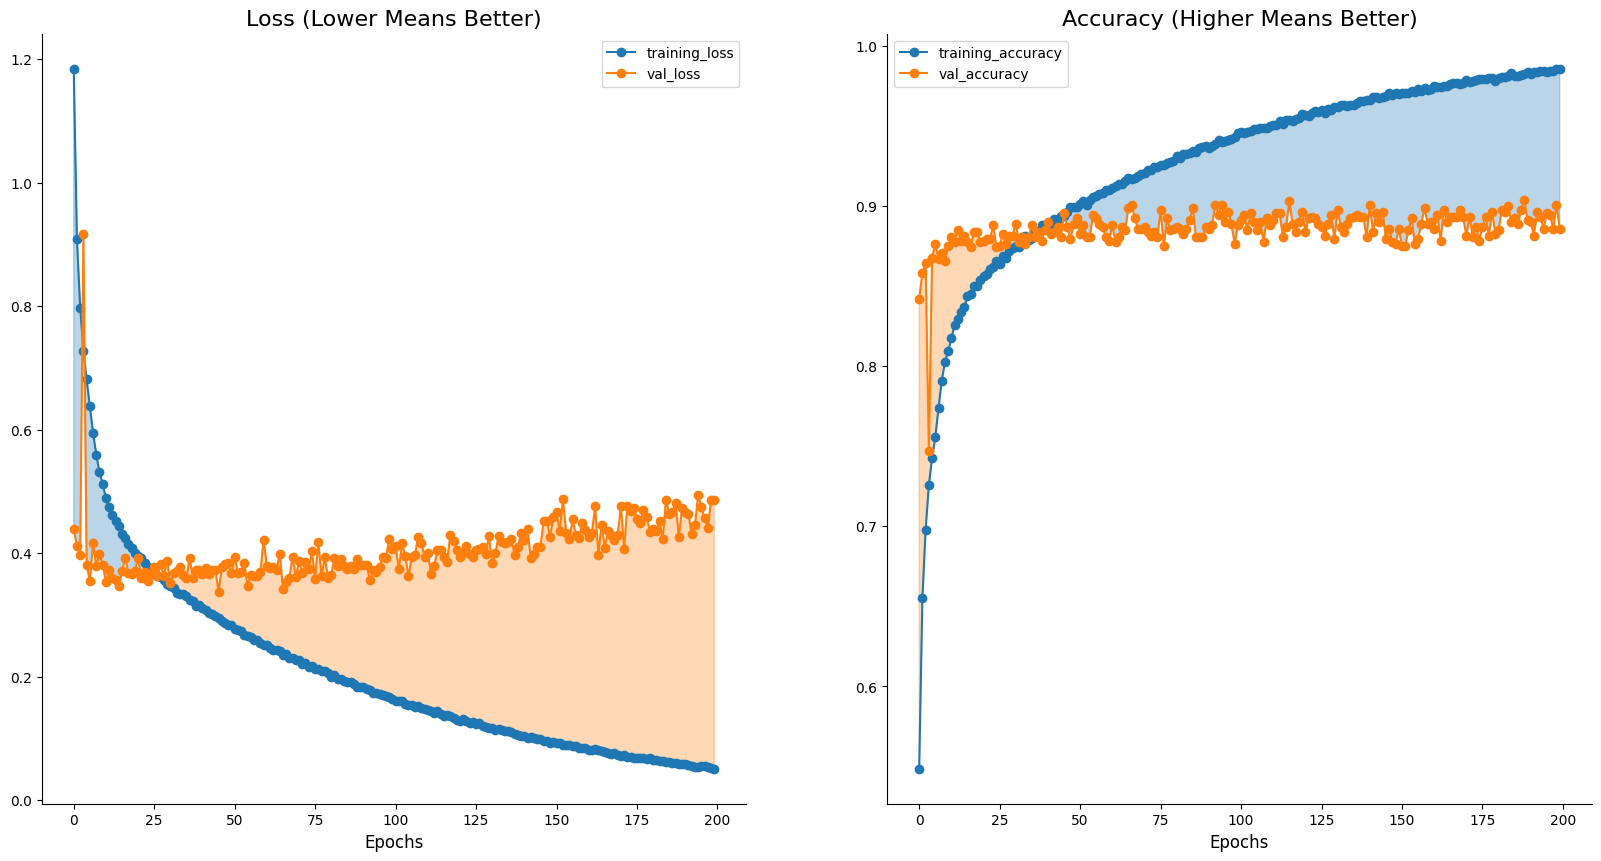

In [30]:
plot_training_curves(history)

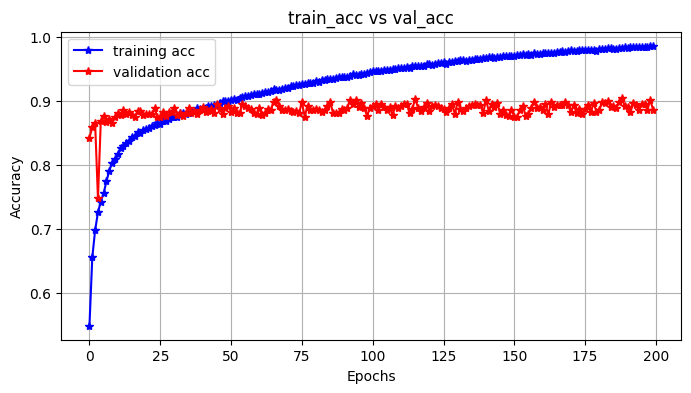

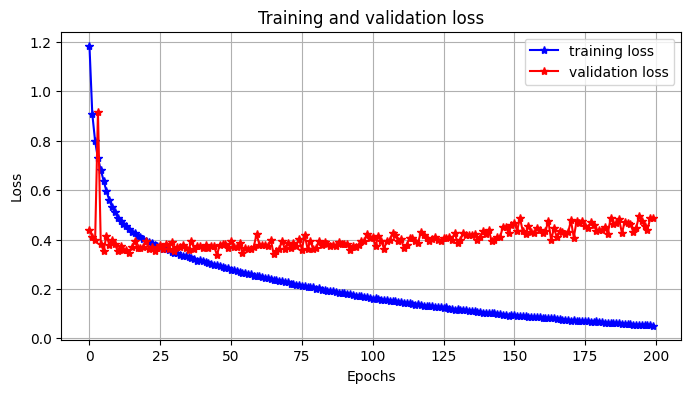

In [31]:
graph(history)

In [32]:
plot_training_curves(history1)

NameError: name 'history1' is not defined

In [33]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()



# argmax returns the index of the max value in a row bl weights ou transfer learning bla augmentation
#cm = confusion_matrix(test_labels, predictions.argmax(axis=1))
# Define the labels of the class indices. These need to match the 
# order shown above.
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']

In [34]:
def metrics(model):  
    predictions = model.predict(test_batches, steps=len(test_batches), verbose=0)
    #geting predictions on test dataset
    y_pred = np.argmax(predictions, axis=1)
    targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
    #getting the true labels per image 
    y_true = test_batches.classes
    #getting the predicted labels per image 
    y_prob=predictions
    from tensorflow.keras.utils import to_categorical
    y_test = to_categorical(y_true)

    # Creating classification report 
    report = classification_report(y_true, y_pred, target_names=targetnames)

    print("Classification Report:")
    print(report)

    print('---------------------------------------------------------------------------------------')
    print("Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
    print("Recall: "+ str(recall_score(y_true, y_pred, average='weighted')))
    print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
    print("weighted Roc score: " + str(roc_auc_score(y_test,y_prob,multi_class='ovr',average='weighted')))

    print('---------------------------------------------------------------------------------------')
    print("Precision: "+ str(precision_score(y_true, y_pred, average='macro')))
    print("Recall: "+ str(recall_score(y_true, y_pred, average='macro')))
    print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
    print("Macro Roc score: " + str(roc_auc_score(y_test,y_prob,multi_class='ovr',average='macro')))
    
    print('---------------------------------------------------------------------------------------')
    print("Precision: "+ str(precision_score(y_true, y_pred, average='micro')))
    print("Recall: "+ str(recall_score(y_true, y_pred, average='micro')))
    print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
    tpr={}
    fpr={}
    roc_auc={}
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_prob.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    print("Micro Roc score: " + str(roc_auc["micro"]))

    print('---------------------------------------------------------------------------------------')
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(7):
        r = roc_auc_score(y_test[:, i], y_prob[:, i])
        print("The ROC AUC score of "+targetnames[i]+" is:" +str(r))

    # Compute ROC curve and ROC area for each class
    fpr = {}
    tpr = {}
    roc_auc = dict()
    for i in range(7):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob[:, i], drop_intermediate=False)
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.plot(fpr[0], tpr[0],'v-',label='akiec: ROC curve of (area = %0.2f)' % roc_auc[0])
    plt.plot(fpr[1], tpr[1],'c',label='bcc: ROC curve of (area = %0.2f)' % roc_auc[1])
    plt.plot(fpr[2], tpr[2],'b',label='bkl: ROC curve of (area = %0.2f)' % roc_auc[2])
    plt.plot(fpr[3], tpr[3],'g',label='df: ROC curve of (area = %0.2f)' % roc_auc[3])
    plt.plot(fpr[4], tpr[4],'y',label='mel: ROC curve of (area = %0.2f)' % roc_auc[4])
    plt.plot(fpr[5], tpr[5],'o-',label='nv: ROC curve of (area = %0.2f)' % roc_auc[5])
    plt.plot(fpr[6], tpr[6],'r',label='vasc: ROC curve of (area = %0.2f)' % roc_auc[6])

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.1, 1.1])
    plt.ylim([-0.1, 1.1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic of %s'%targetnames[i])
    plt.legend(loc="lower right")
    plt.show()
    return predictions

Normalized confusion matrix


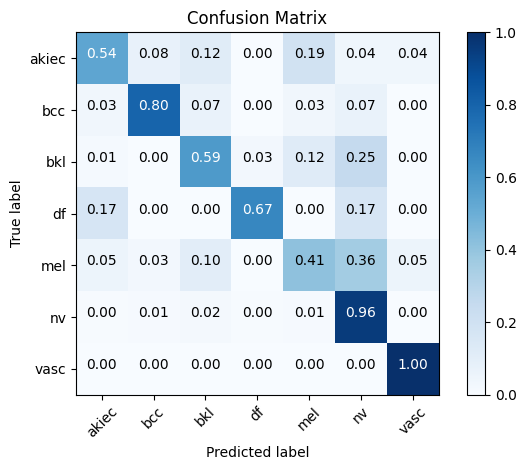

In [35]:
import itertools
test_labels = test_batches.classes
# argmax returns the index of the max value in a row bl weights ou transfer learning bla augmentation
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))
# Define the labels of the class indices. These need to match the 
# order shown above.
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']

plot_confusion_matrix(cm, cm_plot_labels,normalize=True, title='Confusion Matrix')

Classification Report:
              precision    recall  f1-score   support

       akiec       0.64      0.54      0.58        26
         bcc       0.73      0.80      0.76        30
         bkl       0.66      0.59      0.62        75
          df       0.44      0.67      0.53         6
         mel       0.42      0.41      0.42        39
          nv       0.95      0.96      0.95       751
        vasc       0.79      1.00      0.88        11

    accuracy                           0.89       938
   macro avg       0.66      0.71      0.68       938
weighted avg       0.88      0.89      0.88       938

---------------------------------------------------------------------------------------
Precision: 0.884375235221843
Recall: 0.8859275053304904
Accuracy: 0.8859275053304904
weighted Roc score: 0.9698164218999676
---------------------------------------------------------------------------------------
Precision: 0.6603653601097046
Recall: 0.7083014100856977
Accuracy: 0.88592750533

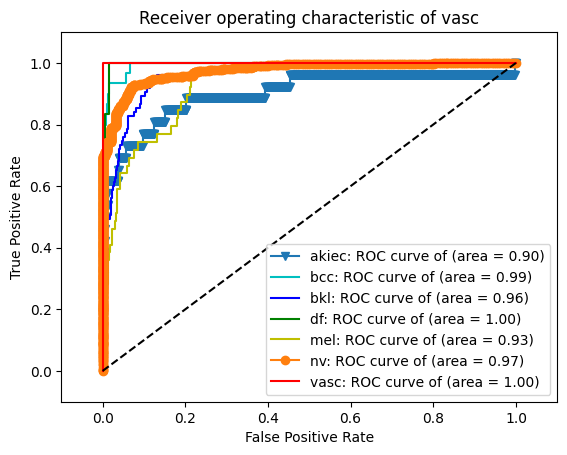

In [37]:
predictions = metrics(model)